In [1]:
from surprise import SVD, KNNBasic, NMF
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
from surprise import Dataset

plt.rcParams['figure.figsize'] = [20, 4]

In [2]:
from surprise import Dataset
from surprise import Reader

# Define the path to the dataset file
file_path = 'ml-100k/u.data'

# Define the rating scale (usually from 1 to 5)
reader = Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1, 5))

# Load the dataset with full information
data = Dataset.load_from_file(file_path, reader=reader)

# Add item genre information to the dataset
item_genre = {}
with open('ml-100k/u.genre', 'r') as f:
    for line in f:
        fields = line.split('|')
        item_id = str(fields[0])
        genre = fields[5:]
        item_genre[item_id] = genre

for item in data.build_full_trainset().all_items():
    item_inner_id = data.to_inner_iid(str(item))
    data.raw_item_ids[item_inner_id] = item_genre[str(item)]

# Build a trainset
trainset = data.build_full_trainset()


AttributeError: 'DatasetAutoFolds' object has no attribute 'to_inner_iid'

# Understanding the dataset

In [ ]:
import pandas as pd
from surprise import Dataset

# Load the ml-100k dataset
data = Dataset.load_builtin('ml-100k')

# Build a dataframe from the dataset
ratings = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
ratings = ratings.drop('timestamp', axis=1)
# Print the first 5 datapoints
ratings.head(5)

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


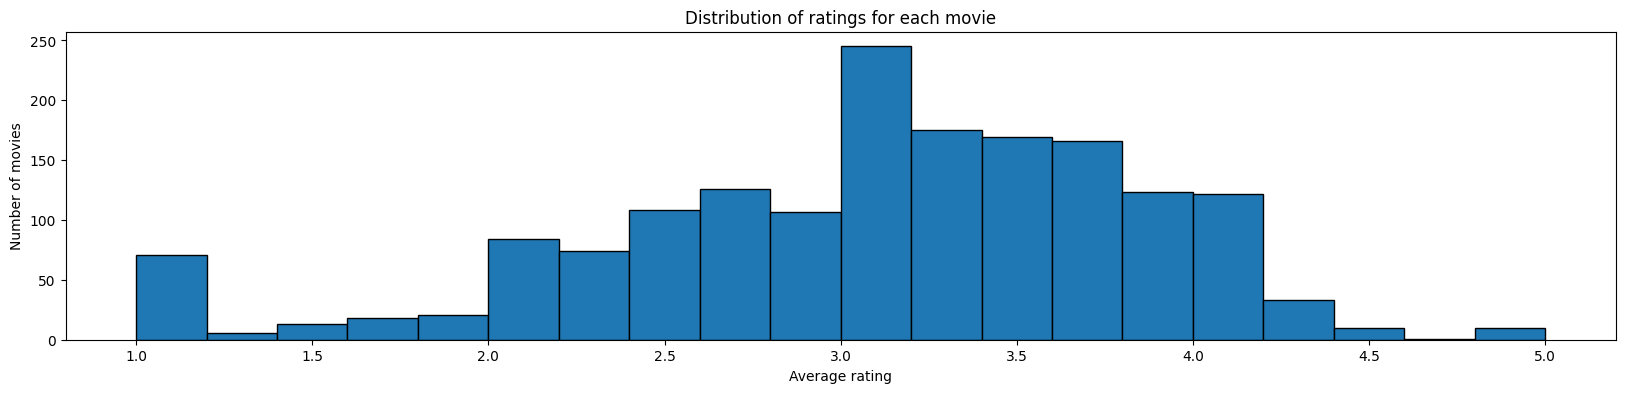

In [ ]:
# Group the ratings by movie
movie_ratings = ratings.groupby('item_id')['rating'].agg(['count', 'mean'])

# Plot the distribution of ratings for each movie
fig, ax = plt.subplots()
ax.hist(movie_ratings['mean'], bins=20, range=(1, 5), edgecolor='black')
ax.set_xlabel('Average rating')
ax.set_ylabel('Number of movies')
ax.set_title('Distribution of ratings for each movie')
plt.show()

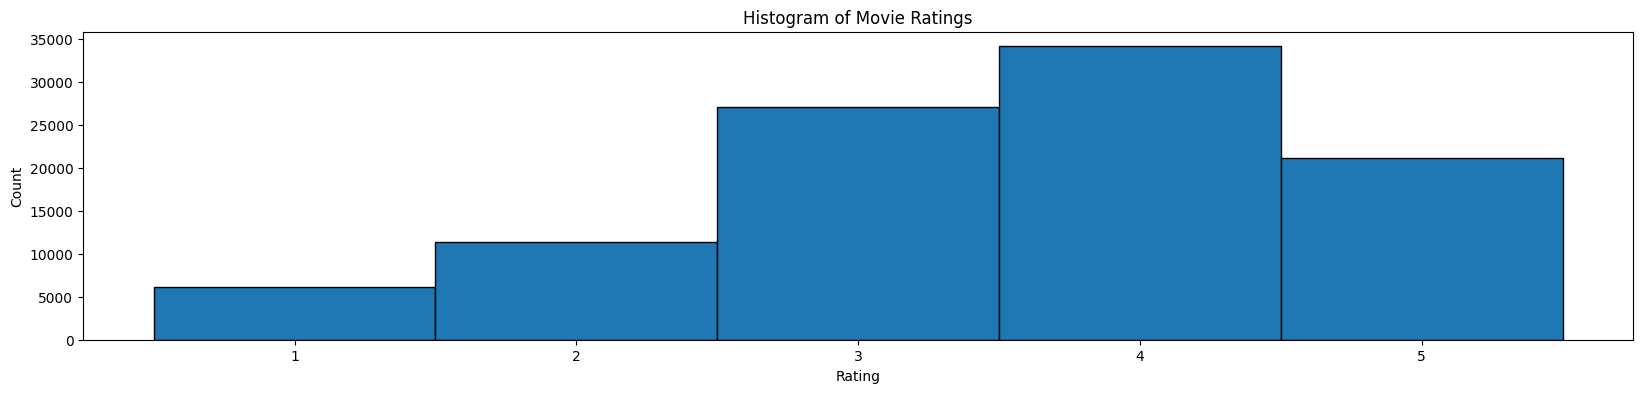

In [ ]:
# Create a histogram of the ratings
plt.hist(ratings['rating'], bins=5, range=(1, 6), edgecolor='black', align='left')

# Set the title and axis labels
plt.title('Histogram of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Set the x-axis tick locations and labels
plt.xticks(range(1, 6), range(1, 6))


# Show the plot
plt.show()


In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)

# Decide the best algorithm for the dataset

In [ ]:


# Load the ml-100k dataset
data = Dataset.load_builtin('ml-100k')

# Define the evaluation metric (in this case, RMSE)
sim_options = {'name': 'cosine', 'user_based': True}

# Define the algorithms to compare
algorithms = [SVD(), KNNBasic(sim_options=sim_options), NMF()]

# Evaluate the algorithms using cross-validation
for algorithm in algorithms:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    print(f"{algorithm.__class__.__name__}: Average RMSE = {sum(results['test_rmse'])/len(results['test_rmse'])}")

# Lowest RMSE is for SVD

SVD: Average RMSE = 0.9360110459172439
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic: Average RMSE = 1.0169885645426657
NMF: Average RMSE = 0.9644027940682905


# Grid search for the best SVD parameters

In [ ]:
# Define the parameter grid for the SVD algorithm
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008], 'reg_all': [0.08, 0.1, 0.15]}

# Define the grid search object and fit it on the dataset
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# Print the best RMSE and MAE scores, along with the corresponding hyperparameters
print(f"Best RMSE score: {gs.best_score['rmse']:.3f}")
print(f"Best MAE score: {gs.best_score['mae']:.3f}")
print(f"Best hyperparameters: {gs.best_params['rmse']}")


Best RMSE score: 0.929
Best MAE score: 0.735
Best hyperparameters: {'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [ ]:
factors = gs.best_params['rmse']['n_factors']
epochs = gs.best_params['rmse']['n_epochs']
lr_value = gs.best_params['rmse']['lr_all']
reg_value = gs.best_params['rmse']['reg_all']

algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

In [ ]:
# Generate predictions for the testing set
predictions = algo.test(testset)

# Calculate and print the RMSE and MAE of the predictions
print(f"RMSE: {accuracy.rmse(predictions)}")
print(f"MAE: {accuracy.mae(predictions)}")

RMSE: 0.9215
RMSE: 0.9215172822558813
MAE:  0.7282
MAE: 0.7282328752677946


In [ ]:
def get_num_user_ratings(uid):
    """ 
    args: 
      uid: user id
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_num_item_ratings(iid):
    """ 
    args:
      iid: the item id
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_num_user_ratings)
df_predictions['Ui'] = df_predictions.iid.apply(get_num_item_ratings)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,393,720,3.0,3.116928,{'was_impossible': False},333,67,0.116928
1,284,751,3.0,3.382588,{'was_impossible': False},33,127,0.382588
2,406,514,1.0,3.809438,{'was_impossible': False},260,139,2.809438
3,928,487,5.0,5.000000,{'was_impossible': False},24,50,0.000000
4,5,235,4.0,2.501192,{'was_impossible': False},131,152,1.498808


In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
7128,427,268,5.0,5.0,{'was_impossible': False},21,210,0.0
13312,462,272,5.0,5.0,{'was_impossible': False},24,159,0.0
15751,862,98,5.0,5.0,{'was_impossible': False},129,301,0.0
5094,405,555,1.0,1.0,{'was_impossible': False},553,9,0.0
24014,907,79,5.0,5.0,{'was_impossible': False},118,260,0.0
17132,440,272,5.0,5.0,{'was_impossible': False},34,159,0.0
13995,200,318,5.0,5.0,{'was_impossible': False},167,225,0.0
2926,405,1207,1.0,1.0,{'was_impossible': False},553,12,0.0
7615,16,12,5.0,5.0,{'was_impossible': False},111,197,0.0
22402,181,991,1.0,1.0,{'was_impossible': False},318,14,0.0


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17618,519,324,1.0,4.335492,{'was_impossible': False},36,91,3.335492
23066,850,56,1.0,4.339088,{'was_impossible': False},32,284,3.339088
8766,343,234,1.0,4.371671,{'was_impossible': False},179,214,3.371671
24496,472,584,1.0,4.411334,{'was_impossible': False},192,54,3.411334
17218,174,168,1.0,4.425033,{'was_impossible': False},136,231,3.425033
13174,97,192,1.0,4.427557,{'was_impossible': False},52,89,3.427557
19271,38,195,1.0,4.447307,{'was_impossible': False},90,219,3.447307
20711,239,190,1.0,4.572385,{'was_impossible': False},122,89,3.572385
8801,481,318,1.0,4.648761,{'was_impossible': False},46,225,3.648761
229,850,98,1.0,4.935310,{'was_impossible': False},32,301,3.935310


In [ ]:
print(predictions[0])

user: 393        item: 720        r_ui = 3.00   est = 3.12   {'was_impossible': False}


# Precision and recall


In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.9411452810180275, 'Recall': 0.1937629142013847},
 {'K': 3, 'Precision': 0.9331919406150564, 'Recall': 0.27676810603908003},
 {'K': 4, 'Precision': 0.9260339342523857, 'Recall': 0.3508416450640934},
 {'K': 5, 'Precision': 0.9234888653234324, 'Recall': 0.41977707259114205},
 {'K': 6, 'Precision': 0.9194591728525998, 'Recall': 0.47663286632234336},
 {'K': 7, 'Precision': 0.9149396556077365, 'Recall': 0.5226372113214731},
 {'K': 8, 'Precision': 0.9094480634247338, 'Recall': 0.5613550203299819},
 {'K': 9, 'Precision': 0.9067969499570816, 'Recall': 0.5961144151935107},
 {'K': 10, 'Precision': 0.9034506556245666, 'Recall': 0.6263170031942762}]

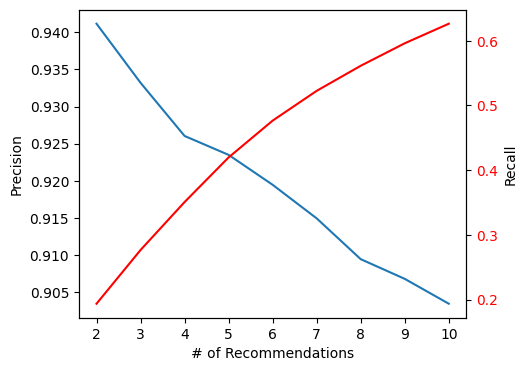

In [ ]:
plt.rcParams['figure.figsize'] = [5, 4]

Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###



# Recommend movies!

In [ ]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [ ]:
# Get the raw user id for user 10
user_id = str(10)

# Extract the predicted ratings for user 10
user_ratings = {}
for uid, iid, true_r, est, _ in predictions:
    if uid == user_id:
        user_ratings[iid] = est

# Sort the items by predicted rating and select the top 5
sorted_ratings = sorted(user_ratings.items(), key=lambda x: x[1], reverse=True)
top_5 = sorted_ratings[:5]

# Print the top 5 recommendations for user 10
print(f"Top 5 recommendations for user {user_id}:")
for item in top_5:
    print(f"\t{item[0]} (predicted rating: {item[1]:.2f})")


Top 5 recommendations for user 10:
	1449 (predicted rating: 4.90)
	318 (predicted rating: 4.87)
	408 (predicted rating: 4.80)
	169 (predicted rating: 4.76)
	114 (predicted rating: 4.71)


In [68]:
import pandas as pd

# Load the dataset into a Pandas dataframe
df = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# Filter the dataframe to only include ratings for user 10
user_10_ratings = df.loc[df['user_id'] == 10]

# Group the ratings by movie ID and calculate the mean rating for each movie
mean_ratings = user_10_ratings.groupby('movie_id')['rating'].mean()

# Sort the mean ratings in descending order and select the top 5 movies
top_5_movies = mean_ratings.sort_values(ascending=False)[:5]

# Get movie_id for the top 5 movies
top_5_movie_ids = top_5_movies.index

# Load the movies dataset into a Pandas dataframe
movies_df = pd.read_csv("ml-100k/u.item", encoding='latin-1', sep="|", names = ["movie_id", "title", "release", "None", "url", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])

top_5 = pd.DataFrame()

for i in range (len(top_5_movie_ids)):
    movie = movies_df.loc[movies_df['movie_id'] == top_5_movie_ids.to_numpy()[i]]
    top_5 = top_5.append(movie)

top_5

/tmp/ipykernel_18805/3319783898.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3319783898.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3319783898.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3319783898.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3319783898.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.appe

,movie_id,title,release,None,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
356,357,One Flew Over the Cuckoo's Nest (1975),01-Jan-1975,NaN,http://us.imdb.com/M/title-exact?One%20Flew%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,179,"Clockwork Orange, A (1971)",01-Jan-1971,NaN,http://us.imdb.com/M/title-exact?Clockwork%20O...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
530,531,Shine (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Shine%20(1996),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
190,191,Amadeus (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Amadeus%20(1984),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
184,185,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


unknown|0
Action|1
Adventure|2
Animation|3
Children's|4
Comedy|5
Crime|6
Documentary|7
Drama|8
Fantasy|9
Film-Noir|10
Horror|11
Musical|12
Mystery|13
Romance|14
Sci-Fi|15
Thriller|16
War|17
Western|18

In [63]:
import pandas as pd

# Load the dataset into a Pandas dataframe
df = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])



/tmp/ipykernel_18805/3929798846.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3929798846.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3929798846.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3929798846.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.append(movie)
/tmp/ipykernel_18805/3929798846.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_5 = top_5.appe

,movie_id,title,release,None,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
356,357,One Flew Over the Cuckoo's Nest (1975),01-Jan-1975,NaN,http://us.imdb.com/M/title-exact?One%20Flew%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,179,"Clockwork Orange, A (1971)",01-Jan-1971,NaN,http://us.imdb.com/M/title-exact?Clockwork%20O...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
530,531,Shine (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Shine%20(1996),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
190,191,Amadeus (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Amadeus%20(1984),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
184,185,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
